# 1. Taks:

Natural Language Processing (NLP) tasks can help businesses use customer reviews to improve their products and services, as well as customer satisfaction. By quickly analyzing vast amounts of data from reviews and extracting meaningful information from it, businesses can identify common topics, trends, and sentiments expressed in the reviews. It help businesses to make better decisions and create better experiences for their customers.

For this dataset, I did the following tasks:

- 1. Clean the customers' review
- 2. Identify common topics and trends in reviews.
- 3. Analyze sentiment of reviews.
- 4. Extract key phrases and terms from reviews.
- 5. Modelling
    - 5.1 Random Forests
    - 5.2 Simpletransformers
- 6. Evaluation of Models.

# 2. About Data

This dataset is from [Kaggle](https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews?select=20191226-reviews.csv). It has over 67,000 `reviews of cell phones from Amazon` from customers who have purchased cell phones from Amazon. 

The dataset has the following columns and with their description:

| **No.** | **Column Name** | **Description** |
| --- | --- | --- |
| 1 | asin | Amazon Standard Identification Number (asin) used by Amazon to track and manage inventory of sold products. |
| 2 | name | Reviewer Name |
| 3 | rating | Reviewer Rating (scale 1 to 5) |
| 4 | date | Review Date |
| 5 | verified | Valid Customer |
| 6 | title | Review Title |
| 7 | body | Review Content |
| 8 | helpfulVotes | Helpful Feedbacks |

# 3. Import neccessary libraries

In [15]:
import pandas as pd
pd.set_option ("max_colwidth", None)
import numpy as np

#sklearn
import sklearn.feature_extraction.text 
import sklearn.metrics.pairwise
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics 
import sklearn.preprocessing 
import sklearn.model_selection 

#nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#string
import re #working with regular expressions
import string
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # analyzing the sentiment of text

#visualization
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#Modelling
import simpletransformers
import simpletransformers.classification
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 4. Get the data

In [9]:
from google.colab import files
uploaded = files.upload()

Saving Amazon_CellPhones_Reviews.csv to Amazon_CellPhones_Reviews.csv


In [16]:
# Read dataset
amazon_review = pd.read_csv('Amazon_CellPhones_Reviews.csv')

# View dataset
print(
    f"{amazon_review.shape[0]: .0f} rows and {amazon_review.shape[1]: .0f} variables in the dataset."
)
amazon_review.head(2)

 67986 rows and  8 variables in the dataset.


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst","I had the Samsung A600 for awhile which is absolute doo doo. You can read my review on it and detect my rage at the stupid thing. It finally died on me so I used this Nokia phone I bought in a garage sale for $1. I wonder y she sold it so cheap?... Bad: ===> I hate the menu. It takes forever to get to what you want because you have to scroll endlessly. Usually phones have numbered categories so u can simply press the # and get where you want to go. ===> It's a pain to put it on silent or vibrate. If you're in class and it rings, you have to turn it off immediately. There's no fast way to silence the damn thing. Always remember to put it on silent! I learned that the hard way. ===> It's so true about the case. It's a mission to get off and will break ur nails in the process. Also, you'll damage the case each time u try. For some reason the phone started giving me problems once I did succeed in opening it. ===> Buttons could be a bit bigger. Vibration could be stronger. Good: ===> Reception is not too shabby. I was using it in the elevator which is a remarkable feat considering my old phone would lose service by simply putting it in my pocket. ===> Compared to my old Samsung, this phone works quite well. The ring tones are loud enough to hear and the phone actually charges quickly and has great battery life. It doesn't heat up like a potatoe in the oven either during long phone convos. ===> Nice bright, large screen. ===> Cute ways to customize it. Scroll bar can be set to purple, pink, aqua, orange, etc. Overall: Okay phone. It serves its purpose but definitely pales in comparison to these new phones coming out from Sprint. Why get so so when you can get great?",1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,"Due to a software issue between Nokia and Sprint this phone's text messaging capabilities don't work with Sprint's system and won't until a software patch comes out ""some time in the next few months"". You will have to spend at least 1 hour with Sprint's award winning customer service team to find someone who will admit this to you. The problem is that Nokia designed their phones so that incoming messages are retrieved quickly and then viewed ""offline"" the way most providers work. Sprint, however, likes to have people hook up to their server first and then stay connected, burning minutes while they check their inbox, compose a reply and wait for the Sprint server to respond so they can send it out. Innovation in money-making at its finest.",17.0


# 5. Data Pre-Processing
Pre-processing the data by tokenizing, stemming, lemmatizing, etc.

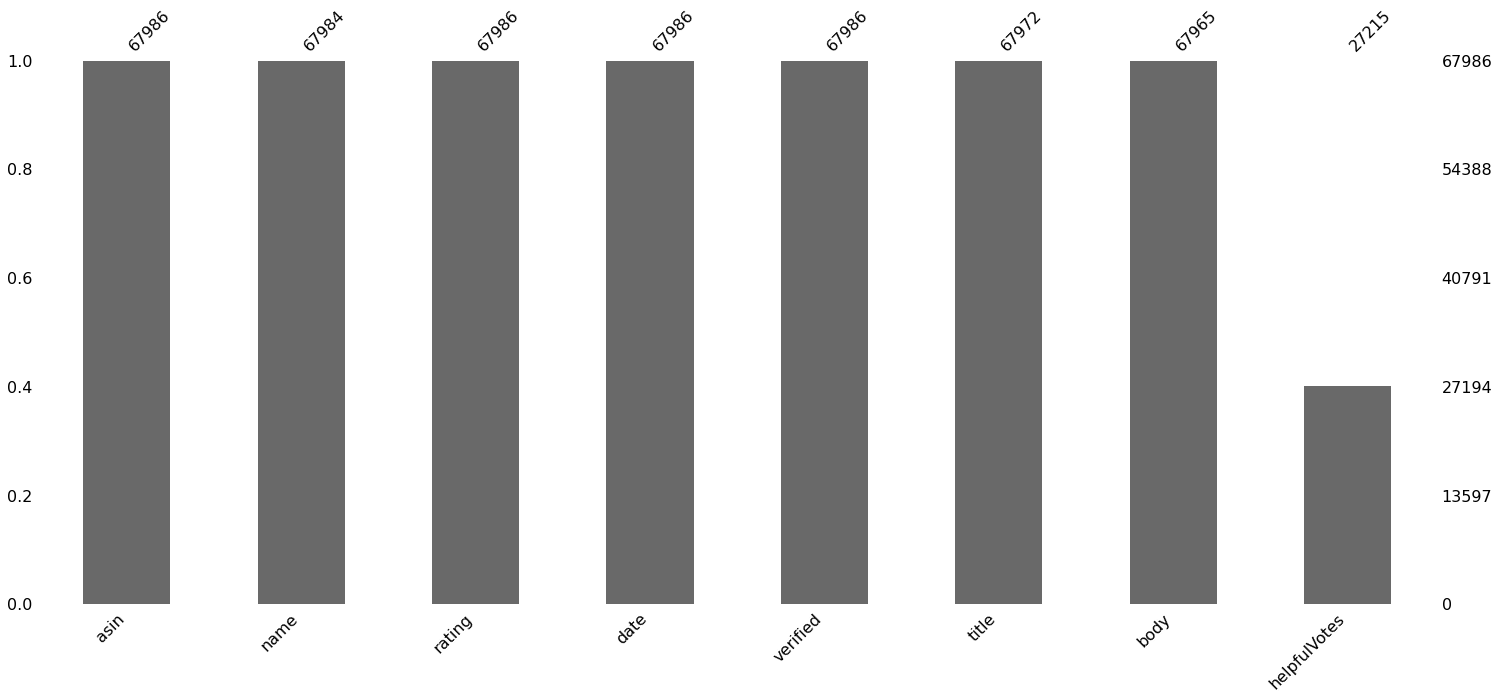

In [17]:
# bar chart of the missing values
msno.bar(amazon_review)

In [18]:
# Remove unnecessary columns

# List of column names to be deleted 
list_of_columns = ['asin', 'name', 'verified', 'helpfulVotes']

# Delete columns 
amazon_review.drop(list_of_columns, axis = 1, inplace = True)

In [19]:
# Convert the body column to string
amazon_review['body'] = amazon_review['body'].astype(str)

# Convert 'date' column to date data type
amazon_review["date"] = pd.to_datetime(amazon_review["date"])

In [20]:
# Arrange the time column in chronological order
amazon_review = amazon_review.sort_values(by='date', ascending=True)

# Set the date column as index
amazon_review.set_index('date', inplace=True)

In [21]:
# Data cleaning
def data_clean(text):
    
    #remove HTML tags
    clean_text = re.sub(r'<.*?>','', text)
    
    #remove punctuation
    for punctuation in string.punctuation:
        clean_text = clean_text.replace(punctuation, '')
    
    #remove numbers
    clean_text = re.sub(r'\d+', '', clean_text)
    
    #make all letters lowercase
    clean_text = clean_text.lower()
    
    #remove whitespace
    clean_text = clean_text.strip()
    
    #lemmatize text
    lemmatizer = WordNetLemmatizer()
    clean_text = ' '.join(lemmatizer.lemmatize(word) for word in clean_text.split())
    
    #remove characters not in English
    clean_text = ''.join(x for x in clean_text if x in string.printable)
    
    #remove stopwords
    tokens = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords])
    
    return clean_text

#apply data cleaning to the reviews
amazon_review['clean_review'] = amazon_review['body'].apply(lambda x: data_clean(x))

This function **data_clean** takes a text as an argument and performs several cleaning tasks on it. It then lemmatizes the text, which is a process of converting words into their base form (e.g. "running" to "run"). Finally, the function removes any stopwords, which are words that don't add any meaning to a sentence (e.g. "a", "the", "of"). 


According to the Datacamp Community article, "Stemming and Lemmatization in Python" (2020), lemmatization is generally considered to be better than stemming for sentiment analysis because it is more accurate and produces more meaningful results. Hence, I used **lemmatization** to normalize the text and make it easier to analyze. 
Lemmatization also helps to reduce the number of words in the text and make it more concise.

In [22]:
def sentiment_vader(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']
    if sentiment_dict['compound'] >= 0.05:
        overall_sentiment = "Positive"
    elif sentiment_dict['compound'] <= -0.05:
        overall_sentiment = "Negative"
    else:
        overall_sentiment = "Neutral"
    return negative, neutral, positive, compound, overall_sentiment

# Apply the sentiment_vader function to the customers' review
amazon_review['customer_review_vader'] = amazon_review['clean_review'].apply(lambda x: sentiment_vader(x))

**VADER**
I used sentiment_vader function to uses the SentimentIntensityAnalyzer from the nltk (Natural Language Toolkit) library to analyze the sentiment of the review. The polarity_scores method of the SentimentIntensityAnalyzer object is used to compute a set of scores for the sentiment of the sentence, including a "compound" score that ranges from -1 (strongly negative) to 1 (strongly positive).

The compound score also calculated to determine the overall sentiment of the sentence as either "Positive", "Negative", or "Neutral". The function returns a tuple containing the negative, neutral, positive, compound, and overall sentiment scores.

Finally, the sentiment_vader function is applied to each row of the clean_review column using the apply method and a lambda function, and the results are stored in a new column called customer_review_vader. This creates a new column in the dataframe containing the sentiment scores for each customer review.

In [23]:
# Analyzing sentiments
sid = SentimentIntensityAnalyzer()
amazon_review["customer_review_scores_nltk"] = amazon_review["clean_review"].apply(
    lambda review: sid.polarity_scores(review)
)
amazon_review["customer_review_compound_nltk"] = amazon_review[
    "customer_review_scores_nltk"
].apply(lambda score_dict: score_dict["compound"])

In [24]:
# Assigning sentiment
amazon_review["sentiment"] = ""
amazon_review.loc[
    amazon_review["customer_review_compound_nltk"] > 0, "sentiment"
] = "Positive"
amazon_review.loc[
    amazon_review["customer_review_compound_nltk"] == 0, "sentiment"
] = "Neutral"
amazon_review.loc[
    amazon_review["customer_review_compound_nltk"] < 0, "sentiment"
] = "Negative"

First I created a new empty column in my dataset (sentiment). Then, the loc method is used to assign the value "Positive" to the sentiment column for all rows where the customer_review_compound_nltk column has a value greater than 0, "Neutral" for all rows where the customer_review_compound_nltk column has a value of 0, and "Negative" for all rows where the customer_review_compound_nltk column has a value less than 0.

This results in the sentiment column being populated with the overall sentiment of each customer review, based on the compound score computed by the SentimentIntensityAnalyzer from the nltk library.

# 6. Visualization

In [26]:
# Create a spaCy nlp object
nlp = spacy.load("en_core_web_sm")

# Extract the hot words from the review column
hotwords = []
counter = 0
for review in amazon_review['clean_review']:
    doc = nlp(review.lower())
    for token in doc:
        if token.pos_ in ['PROPN', 'ADJ', 'NOUN'] and counter < 30:
            hotwords.append(token.text)
            counter += 1

# Print the hot words
print(hotwords)

['nokia', 'phone', 'phone', 'alot', 'reception', 'greateven', 'signal', 'strength', 'low', 'quality', 'phone', 'great', 'sturdy', 'weighted', 'phone', 'reliable', 'phone', 'phone', 'samsung', 'comprehendable', 'speed', 'dialing', 'available', 'number', 'voice', 'dialing', 'nice', 'feature', 'dialing', 'thing']


I used **spaCy** library to extract the hot words from the 'clean_review' column. I used the nlp() function to create a document object from each review and then looping through the tokens in the document. If the token's part of speech is one of the specified tags and the counter is less than 30, it is appended to the list of hot words. Finally, the list of hot words is printed.

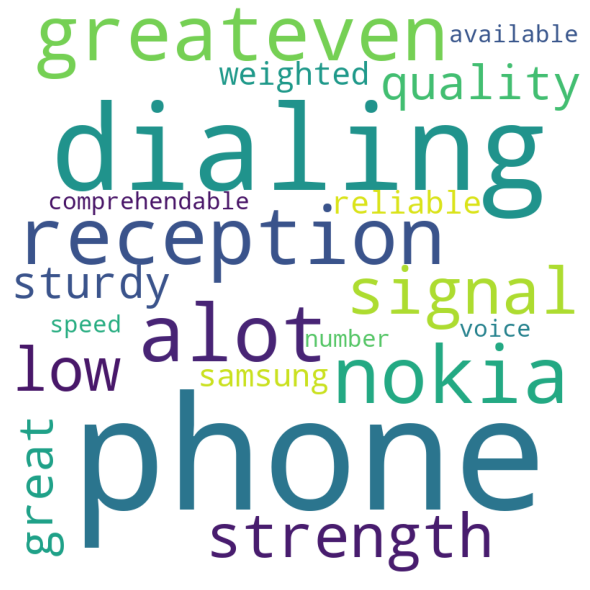

In [27]:
#Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=20).generate(' '.join(hotwords)) 

# Plot the WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

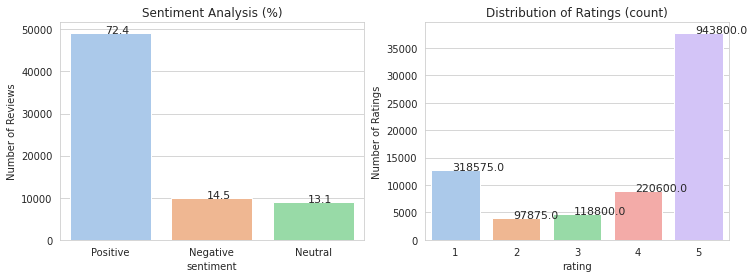

In [28]:
#visualizing sentiments
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x1 = 'sentiment'
y1 = 'Number of Reviews'
data1 = amazon_review
palette1 = "pastel"
title1 = 'Sentiment Analysis (%)'
total1 = len(amazon_review)

x2 = 'rating'
y2 = 'Number of Ratings'
data2 = review
palette2 = "pastel"
title2 = 'Distribution of Ratings (count)'
total2 = len(review)

ax[0] = sns.countplot(x=x1, data=amazon_review, palette=palette1, ax=ax[0])
ax[0].set_title(title1)
ax[0].set_xlabel(x1)
ax[0].set_ylabel(y1)

ax[1] = sns.countplot(x=x2, data=amazon_review, palette=palette2, ax=ax[1])
ax[1].set_title(title2)
ax[1].set_xlabel(x2)
ax[1].set_ylabel(y2)

#adding percentages to the plots
for i, p in enumerate([ax[0].patches, ax[1].patches]):
    total = [total1, total2][i]
    for patch in p:
        percentage = '{:.1f}'.format(100 * patch.get_height()/total)
        x = patch.get_x() + patch.get_width() / 2 - 0.05
        y = patch.get_y() + patch.get_height() + 0.01
        ax[i].annotate(percentage, (x, y), size = 11)

plt.show()

# 7. Feature Engineering

In [32]:
le = sklearn.preprocessing.LabelEncoder()
amazon_review["sentiment_encoded"] = le.fit_transform(amazon_review["sentiment"])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    amazon_review["clean_review"], amazon_review["sentiment_encoded"]
)
train_df = pd.DataFrame({"text": X_train, "labels": y_train})
test_df = pd.DataFrame({"text": X_test, "Labels": y_test})

# 8. Modelling

## 8.1 Random Forests

I applied Random Forests Model for sentiment analysis because the model can handle a large number of features and handle complex relationships between features and the target. Random forests are able to do this by constructing multiple decision trees and averaging their predictions, which can help reduce overfitting and improve generalization to new data.

Also, the model is relatively easy to interpret and can provide insight into the features that are most important for predicting the target. This can be useful for understanding the factors that are driving the sentiment of the text and identifying patterns in the data.

According to a study by Poria et al. (2017), random forests can be effective for sentiment analysis when combined with feature engineering such as feature selection and dimensionality reduction. The study found that random forests outperformed other classifiers, including support vector machines and logistic regression, on a dataset of movie reviews.

In summary, random forests can be a good choice for sentiment analysis due to their ability to handle a large number of features, handle complex relationships between features and the target, and provide

In [34]:
# Define the pipeline
pipeline = Pipeline([
    ("vect", CountVectorizer()),  # Convert the review text to a bag-of-words representation
    ("clf", RandomForestClassifier())  # Train a random forest classifier
])


In [35]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', RandomForestClassifier())])

In [36]:
# Evaluate the model on the test data
accuracy = pipeline.score(X_test, y_test)

# Print the accuracy
print(f"Test accuracy: {accuracy:.2f}")

Test accuracy: 0.88


In [37]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test data using the model in the pipeline
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(conf_matrix)

[[  933   170  1354]
 [   16  1958   254]
 [   80   234 11998]]


## 8.2 Transformer-based - Roberta 

The **simpletransformers** library is a wrapper for the Transformers library. It makes easier to use powerful language models like RoBERTa and I use simpletransformers for sentiment analysis.

In [19]:
model = simpletransformers.classification.ClassificationModel(
    "roberta", #specify the type of model to use
    "roberta-base", #specify the specific version of the RoBERTa model to use
    use_cuda=True, #use GPU
    num_labels=amazon_review["sentiment_encoded"].nunique(), #specify the number of unique labels in the target column (sentiment_encoded).
    args={ #additional arguments to pass
        "overwrite_output_dir": True, #overwrite the output directory if it already exists
        "save_model_every_epoch": False, #not to save a copy of the model after every epoch of training
        "num_train_epochs": 2, #number of iterations over the entire dataset to train the model
    },
)
model.train_model(train_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/50989 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/6374 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/6374 [00:00<?, ?it/s]

(12748, 0.24706421752481414)

In [20]:
# Test Training Model

result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)
cm = sklearn.metrics.confusion_matrix(y_test, np.argmax(model_outputs, axis=1))
print(result)
print(le.classes_)
print(cm)

/usr/local/lib/python3.8/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/16997 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2125 [00:00<?, ?it/s]

{'mcc': 0.9107753781868838, 'acc': 0.96175795728658, 'eval_loss': 0.16823428857501815}
['Negative' 'Neutral' 'Positive']
[[ 2098    24   308]
 [   52  2088    48]
 [  177    41 12161]]


# 9. Conclusion

Based on the accuracy scores and confusion matrices for both models, the **simpletransformers model** performed better than the random forest model for sentiment analysis. The simpletransformers model has an accuracy of 96%, while the random forest model has an accuracy of 88%.

The confusion matrices also provide more detailed information about the performance of the models.

In the case of the random forest model, the confusion matrix shows that the model is making more errors than the simpletransformers model. The random forest model is misclassifying more negative reviews as positive, as indicated by the higher number of false positives (170) compared to the simpletransformers model (24). Similarly, the random forest model is misclassifying more positive reviews as negative, as indicated by the higher number of false negatives (80) compared to the simpletransformers model (41).

Overall, it looks like the simpletransformers model is performing better on this dataset, but it is always a good idea to carefully evaluate the performance of a model using multiple metrics and consider the specific requirements of your application.

# 10. Refrences

https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

https://nlp.stanford.edu/sentiment/index.html

Poria, S., Cambria, E., Hazarika, D., Zadeh, A., Morency, L.-P., & Bajpai, R. (2017). Aspect extraction for sentiment analysis: A survey. IEEE Access, 5, 18345-18361.
